# Алгоритмы интеллектуальной обработки больших объемов данных
## Домашнее задание №5 - Алгоритмы кластеризации


###### <hr\>
**Общая информация**

**Срок сдачи:** 17 декабря 2018, 06:00 <br\>
**Штраф за опоздание:** -2 балла после 06:00 17 декабря, -4 балла после 06:00 24 декабря, -6 баллов после 06:00 31 декабря -8 баллов  после 06:00 7 января


Используйте данный Ipython Notebook при оформлении домашнего задания.
<hr\>

**Из чего состоит задание:**

###### Теоретические вопросы (2 балла)

###### Реализация алгоритма кластеризации (6 баллов)

###### Боевое применение (2 балла)




**Штрафные баллы:**

1. Невыполнение PEP8 -1 балл
2. Отсутствие фамилии в имени скрипта (скрипт должен называться по аналогии со stroykova_hw4.ipynb) -1 балл
3. Все строчки должны быть выполнены. Нужно, чтобы output команды можно было увидеть уже в git'е. В противном случае -1 балл
4. При оформлении ДЗ нужно пользоваться данным файлом в качестве шаблона. Не нужно удалять и видоизменять написанный код и текст. В противном случае -1 балл

# Определяем, что вам досталось

Укажите свою фамилию на русском языке в поле ниже.

In [1]:
import hashlib

def lucky_hash(text):
    return int(hashlib.md5(text.encode('utf-8')).hexdigest()[:8], 16) 

USER_NAME = u"Кулис".lower()

ALGORITHMS = [
    u"Gaussian Mixture Model с использованием maximum a-posteriori для выбора кластера (параметр - число кластеров)",
    u"Hierarchical clustering с поддержкой single-linkage, complete-linkage, average-linkage (параметры - число кластеров, linkage)",]

print ("Имплементируйте алгоритм кластеризации %s"\
% (
    ALGORITHMS[lucky_hash(USER_NAME[::-1]) % 2]
) )

Имплементируйте алгоритм кластеризации Hierarchical clustering с поддержкой single-linkage, complete-linkage, average-linkage (параметры - число кластеров, linkage)


Не стоит переживать из-за Вашего варианта. Технически оба алгоритма несложно реализовать.  EM алгоритма бояться не стоит, Вам будет нужно просто реализовать уже выведенные формулы для E и M шагов.

In [2]:
import time
import pandas as pd
import pylab as pl
import numpy as np
import scipy.spatial as ss
import sklearn.cluster as sc
import sklearn.manifold as sm
import sklearn.datasets as ds
import sklearn.metrics as smt
from sklearn.metrics import pairwise_distances
from sklearn.mixture import GaussianMixture
from sklearn.cluster import AgglomerativeClustering

import matplotlib.pyplot as plt

%matplotlib inline

plt.style.use('ggplot')
plt.rcParams['figure.figsize'] = (12,5)

# Plotting config
%pylab inline
%load_ext pycodestyle_magic

Populating the interactive namespace from numpy and matplotlib


# Теоретическое введение


Основная задача кластерного анализа — разбиение исходного набора объектов на группы (кластеры) таким образом, чтобы объекты в группе были похожи друг на друга, а объекты из разных групп - отличались. 

В этой работе мы будем реализовывать один из двух популярных методов кластеризации: разделение смеси нормальных распределений или агломеративную кластеризацию. 

## Смесь нормальных распределений



Предполагаем, что наши данные порождены смесью $k$ нормальных распределений, то есть 

$$ p(\mathbf{x}) = \sum_k \pi_k \mathcal{N}(\mathbf{x} | \mathbf{\mu}_k, \mathbf{\Sigma}_k) $$,


где $\mathcal{N}$ - многомерное нормальное распределение размерности ${D}$:

$$\mathcal{N(\mathbf{x} | \mathbf{\mu}, \mathbf{\Sigma}}) = \frac{1}{(2 \pi)^{D/2}} \frac{1}{|\mathbf{\Sigma}|^{1/2}} \exp \left\{-\frac{1}{2}(\mathbf{x} - \mathbf{\mu})^T \mathbf{\Sigma^{-1}} (\mathbf{x} - \mathbf{\mu})\right\}$$

**Параметры**  


${D}$-мерный вектор средних

$$\mathbf{\mu}$$

$D \times D$-мерная матрица ковариации   (симметричная)


$$\mathbf{\Sigma} = E[(\mathbf{x} - \mathbf{\mu})(\mathbf{x} - \mathbf{\mu})^T]$$



Необходимо оценить параметры $\pi_k, \mathbf{\mu_k}, \mathbf{\Sigma_k} $ для всех компонент смеси.  Сделать это можно с помощью EM алгоритма - алгоритма, который находит оценку максимального правдоподобия в задаче со скрытыми переменными. 

## Expectation Maximization

**I** До цикла проинциализировать случайно  $\mu_k, \Sigma_k, \pi_k$ ($\pi_k$ должны суммироваться в 1)

**E** Expectation: при фиксированных $\mu_k, \Sigma_k, \pi_k$
$$
p(z_k = 1| x_n ) = \gamma(z_{nk}) = \frac{\pi_k \mathcal{N} (\mathbf{x}_n | \mu_k, \Sigma_k)}{\sum_{j=1}^K \pi_j \mathcal{N} (\mathbf{x}_n | \mu_j, \Sigma_j)}
$$
**M** Maximization: при фиксированных $\gamma(z_{nk})$
$$
N_k = \sum_{n=1}^N \gamma(z_{nk}), \;\; \mu_k = \frac 1 {N_k} \sum_{n=1}^N \gamma(z_{nk}) \mathbf{x}_n
$$
$$
\Sigma_k = \frac 1 {N_k} \sum_{n=1}^N \gamma(z_{nk}) (\mathbf{x}_n - \mu_k)(\mathbf{x}_n - \mu_k)^T
$$
$$
\pi_k = \frac{N_k}{N}
$$
**S** Остановиться при достижении сходимости

Номер кластера для $n$ объекта будем брать по принципу maximum a-posteriori, то есть относить объект к тому кластеру, у которого максимальна апостериорная вероятность:
$$ k_n =  \arg\underset{k}\max  p(z_k = 1| x_n ) =  \arg\underset{k}\max \gamma(z_{nk}) $$

## Агломеративная кластеризация

Иерархические алгоритмы кластеризации строят на выборке систему вложенных разбиений.  Наиболее часто испоьзуемые иерархические алгоритмы - агломеративные алгоритмы, которые строят ирархию по восходящей, то есть от момента, когда все элементы являются отдельными кластерами, до того момента, пока вся выборка не станет одним кластером.

Сам алгоритм описать можно примерно так:

* начинаем с ситуации, когда каждый объект - отдельный кластер
* на каждом шаге совмещаем два наиболее близких кластера
* останавливаемся, когда получаем требуемое количество или единственный кластер


В данной работе Вам предлагается реализовать три варианта расстояний между кластерами, по которым Вы определяете пару для слияния: 
* Single linkage
$$ d_{min}(C_i, C_j) = \min_{\mathbf{x} \in C_i, \mathbf{x}' \in C_j} \|\mathbf{x} -\mathbf{x}' \| $$

* Complete linkage
$$ d_{max}(C_i, C_j) = \max_{\mathbf{x} \in C_i, \mathbf{x}' \in C_j} \|\mathbf{x} -\mathbf{x}' \| $$

* Average linkage
$$ d_{avg}(C_i, C_j) = \frac{1}{n_i n_j}\sum_{\mathbf{x} \in C_i}\sum_{\mathbf{x}' \in C_j} \|\mathbf{x} -\mathbf{x}' \| $$

Для простоты будем использовать евклидово расстояние между объектами.



Для того, чтобы на втором этапе нам не пересчитывать заново расстояния между всеми парами кластеров, можно использовать Формулы Ланса-Вильямса, которые позволяют посчитать расстояние между кластерами после объединения, используя только расстояния между кластерами до объедения.  Таким образом, достаточно будет посчитать расстояния только между всеми одноэлементными кластерами (первый этап), а затем пересчитывать расстояния при их объединении через 
формулы Ланса-Вильямса. 

Общая  формула выглядит так:
$$ d(C_i \cup C_j, C_k) = a_i \cdot d(C_i, C_k) + a_j \cdot d(C_j, C_k) + b \cdot d(C_i, C_j) + c \cdot |d(C_i, C_k) - d(C_j, C_k)|$$

Можно показать, что все относительно разумные кластерные расстояния можно описать данной формулой. 

Для интересущих нас linkage:

* single-linkage       $a_i = \frac{1}{2}, a_j =  \frac{1}{2}, b = 0, c =  - \frac{1}{2} $

* complete-linkage     $a_i = \frac{1}{2}, a_j =  \frac{1}{2}, b = 0, c =   \frac{1}{2} $

* average-linkage       $a_i = \frac{|C_i|}{|C_i \cup C_j|}, a_j =  \frac{|C_j|}{|C_i \cup C_j|}, b = 0, c = 0 $



# Теоретические вопросы (2 балла)
В этой части Вам будут предложены теоретичские вопросы и задачи по теме. Вы, конечно, можете списать их у своего товарища или найти решение в интернете, но учтите, что они обязательно войдут в теоретический коллоквиум. Лучше разобраться в теме сейчас и успешно ответить на коллоквиуме, чем списать, не разобравшись в материале, и быть терзаемым совестью. 


Формулы надо оформлять в формате **LaTeX**.

Задача 1. Сходимость kmeans.

Метод kmeans является частным случаем EM алгоритма и наиболее простым в обосновании сходимости. Докажите, что kmeans всегда сходится, и итераций не будет превышать $k^N$, где $k$ $-$ число кластеров, $N$ $-$ число объектов

Подсказка: Вам стоит рассмотреть функционал, который минимизирует алгоритм, и подумать, как он изменяется на E шаге и на M шаге.



***Ваше решение здесь***

$$L(C) = \sum_{i=1}^k\sum_{x_j \in C_i}||x_j - \mu_i||^2$$

$$шаг\space E:$$
$$x \in C_i\space если\space i = argmin_{i=0, ..., k}||x - \mu_i||$$

$$шаг\space M:$$
$$\mu_i = \frac{1}{|C_i|}\sum_{x\in C_i}x$$

На каждом шаге $\mu_i$ сдвигается к среднему значению элементов, для которых $\mu_i$ является ближайшим, после чего расстояния снова пересчитываются, и элементы выборки могут принадлежать уже другому кластеру. Всего кластеров k, а элементов выборки - N => всего возможных способов распределения элементов выборки по класетерам - $k^N$. 
Таким образом, на следующем шаге алгоритма возможны 3 случая:

1) Принадлежность элементов выборки к классам не изменится. Тогда и на всех последующих шагах элементы будут принадлежать тем же классам, так как положение центров кластеров $\mu_i$ не будет меняться. Алгоритм сошёлся.

2) Один или несколько элементов выборки начнут принадлежать другим кластерам (так как изменились координаты центров кластеров), и получилось новое, не встречавшееся до этого распределение элементов выборки по кластерам.

3) Всё то же самое, что и в пункте 2), но новое распределение элементов выборки по кластерам уже встречалось в предыдущих итерациях алгоритма.

Так как на шаге Е мы для каждого $x_i$ выбираем ближайшие $\mu_j$, то L(C) уменьшается, так как расстояния пересчитываются для более близких кластеров. На шаге М: для каждого кластера С его центр сменяется на среднее элементов кластера, таким образом L(C) для кластера уменьшается $\Rightarrow L_{n+1}(C) < L_{n}(C)$. Таким образом, 3 невозможен, а для второго возможно только $k^N$ вариантов $\Rightarrow$ алгоритм сходится меньше чем за $k^N$ шагов.


Задача 2. Сходимость EM.

Разобравшись со сходимостью kmeans, можно догадаться и до ответа про EM алгоритм.

При каком условии на правдоподобие системы EM алгоритм будет  сходиться?



***Ваше решение здесь***

Скорее всего - непрерывность на замкнутом и ограниченном множестве. Таким образом создаются условия для существования максимума функции.

Задача 3. Формулы Ланса-Вильямса.

Формулы Ланса-Вильямса крайне удобны для быстрого пересчта расстояний в агломеративной кластеризации. Давайте докажем  формулы для single и complete linkage. 

Докажите, что:

$d_{\min}(U \cup V, S) = \frac{1}{2} d_{\min}(U, S) + \frac{1}{2} d_{\min}(V, S)  - \frac{1}{2} | d_{\min}(U, S) - d_{\min}(V, S) |  $


$d_{\max}(U \cup V, S) = \frac{1}{2} d_{\max}(U, S) + \frac{1}{2} d_{\max}(V, S)  + \frac{1}{2} | d_{\max}(U, S) - d_{\max}(V, S) |  $




***Ваше решение здесь***

$\min(x, y) = \frac{1}{2}(x + y) - \frac{1}{2}|x-y| \\ 
\max(x, y) = \frac{1}{2}(x + y) + \frac{1}{2}|x-y| \\
d_{\min}(U \cup V, S) = min(d_{\min}(U, S),~d_{\min}(V, S)) = \frac{1}{2} d_{\min}(U, S) + \frac{1}{2} d_{\min}(V, S)  - \frac{1}{2} | d_{\min}(U, S) - d_{\min}(V, S) |\\
d_{\max}(U \cup V, S) = min(d_{\max}(U, S),~d_{\max}(V, S)) = \frac{1}{2} d_{\max}(U, S) + \frac{1}{2} d_{\max}(V, S)  - \frac{1}{2} | d_{\max}(U, S) - d_{\max}(V, S) |$

# Реализация алгоритма кластеризации  (6 баллов)

Алгоритм кластеризации должен удовлетворять следующему интерфейсу. Конструктор принимает набор параметров, необходимых для работы алгоритма кластеризации. Метод `fit` подсчитывает параметры модели и возвращает `self`. Метод `predict` возвращает вектор с индексами кластеров для поданных в него объектов `x`. 

In [3]:
# %%pycodestyle
from sklearn.base import BaseEstimator, ClusterMixin


class Clustering(BaseEstimator, ClusterMixin):
    """
    Implement clustering algorithm according
    """

    def __init__(self, n_clusters, linkage):
        """
        Please add necessary algoritm parameters to class constructor.
        """
        self.n_clusters = n_clusters
        if linkage == "single":
            self.coefs = self.single
        elif linkage == "complete":
            self.coefs = self.complete
        else:
            self.coefs = self.average
        return

    def single(self, C_i, C_j, C_ij):
        return 0.5, 0.5, -0.5

    def complete(self, C_i, C_j, C_ij):
        return 0.5, 0.5, 0.5

    def average(self, C_i, C_j, C_ij):
        return C_i.sum() / C_ij.sum(), C_j.sum() / C_ij.sum(), 0

    def merge_clusters(self, clust_i, clust_j):
        # Получаем маску нового кластера
        clust_ij = np.logical_or(self.clusters[clust_i],
                                 self.clusters[clust_j])

        # Коэффициенты для формулы Ланса-Вильямса
        ai, aj, c = self.coefs(self.clusters[clust_i],
                               self.clusters[clust_j],
                               clust_ij)

        # Расстояния от нового кластера до всех остальных
        dists_ij = (ai * self.dists[clust_i] + aj * self.dists[clust_j] +
                    c * np.abs(self.dists[clust_i] - self.dists[clust_j]))

        # Теперь избавляемся от кластеров i, j, и добавляем их объединение.
        # Удаляем кластер j, а объединение ставим на место кластера i.

        # Меняем расстояния кластера i на расстояния объединения i и j:
        self.dists[clust_i] = dists_ij
        self.dists[:, clust_i] = dists_ij

        # Получится так, что расстояние от нового класстера до
        # самого себя будет > 0,
        # поэтому зануляем
        self.dists[clust_i, clust_i] = 0

        # удаляем расстояния кластера j
        self.dists = np.delete(np.delete(self.dists, (clust_j), axis=0),
                               (clust_j), axis=1)

        # то же самое с матрицой принадлежности выборки к кластерам
        self.clusters[clust_i] = clust_ij
        self.clusters = np.delete(self.clusters, (clust_j), axis=0)

    def fit(self, x, y=None):
        """
        Use data matrix x to compute model parameters
        """
        self.x_len = len(x)

        # Строки - кластеры, столбцы - элементы выборки.
        # В матрице содержится флаг - принадлежность элемента к кластеру
        self.clusters = np.eye(len(x), dtype=bool)

        # Расстояния между кластерами
        self.dists = pairwise_distances(x, x)

        # Бегаем в цикле, пока количество кластеров не уменьшится
        # до нужного количества
        for num_clusters in range(self.x_len, self.n_clusters, -1):
            # Немножечко магии, находим ближайши кластеры
            ind = np.argpartition(self.dists.reshape(-1),
                                  num_clusters)[:num_clusters + 1]
            nearest_clusters = np.array([ind // num_clusters,
                                         ind % num_clusters])
            clust_i, clust_j = nearest_clusters[:, nearest_clusters[0] !=
                                                nearest_clusters[1]].T[0]
            # Объединяем кластеры
            self.merge_clusters(clust_i, clust_j)

        # Получили метки кластеров (нужно для fit_predict)
        self.labels_ = self.clusters.argmax(axis=0)
        return self

    def predict(self, x):
        """
        Using computed model parameters predict cluster
        for all objects from x
        """
        return self.clusters.argmax(axis=0)

Сначала проверим реализованный алгоритм кластеризации на классическом наборе данных [Iris](http://www.wikiwand.com/en/Iris_flower_data_set). Загрузим данные (они включены в библиотеку sklearn) и посмотрим на то, как они выглядят в двух проекциях (для простоты используем 2 класса из 3).

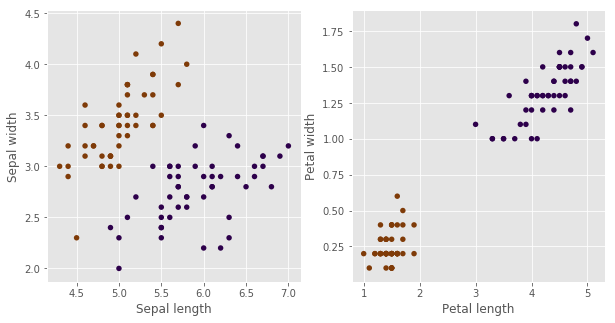

In [4]:
iris = ds.load_iris()
x_iris = iris.data[:100]
y_iris = iris.target[:100]

pl.figure(figsize=(10, 5))

pl.subplot(1, 2, 1)
pl.scatter(x_iris[:, 0], x_iris[:, 1], c=y_iris, cmap=pl.cm.PuOr, lw=0, s=30)
plt.xlabel('Sepal length')
plt.ylabel('Sepal width')

pl.subplot(1, 2, 2)
pl.scatter(x_iris[:, 2], x_iris[:, 3], c=y_iris, cmap=pl.cm.PuOr, lw=0, s=30)
plt.xlabel('Petal length')
plt.ylabel('Petal width')
pl.show()

Видно, что классы разделяются, поэтому можно надеяться, что наш алгоритм "найдет" кластеры, соответствующие исходным классам. Результат работы реализованного алгоритма кластеризации предлагается сравнить с эталонной кластеризацией. Для этого предлагается изучить метрику ([adjusted rand score](http://scikit-learn.org/stable/modules/generated/sklearn.metrics.adjusted_rand_score.html)). В случае если значение этой метрики отличается от 1, предлагается поработать над улучшением реализации своего алгоритма.

In [5]:
pred_iris = Clustering(2, 'single').fit_predict(x_iris)
# pred_iris = [ 0 ] * len(y_iris)
print ("Adjusted Rand index for iris is: %.2f" % smt.adjusted_rand_score(y_iris, pred_iris))

Adjusted Rand index for iris is: 1.00


In [6]:
# Давайте проверим, как справляются sklearn реализации
sklearn_gmm = GaussianMixture(n_components=2)
gmm_t0 = time.time()
sklearn_gmm.fit(x_iris)
gmm_diff = time.time() - gmm_t0
gmm_score = smt.adjusted_rand_score(y_iris, sklearn_gmm.predict(x_iris))

sklearn_aggl = AgglomerativeClustering(n_clusters=2)
aggl_t0 = time.time()
aggl_pred = sklearn_aggl.fit_predict(x_iris)
aggl_diff = time.time() - aggl_t0
aggl_score = smt.adjusted_rand_score(y_iris, aggl_pred)
print ("GMM score {}. GMM time {}. AGGL score {}. AGGL time {}".format(gmm_score, gmm_diff, aggl_score, aggl_diff))

GMM score 1.0. GMM time 0.010969877243041992. AGGL score 1.0. AGGL time 0.08377671241760254


Сверьте Ваш алгоритм с этими числами. Уверен, что у Вас получится не хуже!

# Боевое применение (2  балла)


Алгоритмы кластеризации прекрасны тем, что они позволяют быстро понять, как устроены наши данные. Давайте применим Ваш алгоритм для анализа реальной задачи!

Важное замечание: в этой части задания студенту самому предлагается разобраться с данными и их форматом в качестве полезного упраженения. Не принимайте это близко к сердцу :)

Ввозьмем датасет различных стран.  
Данные нужно скачать тут https://data.worldbank.org/data-catalog/world-development-indicators.   


Подход следующий: фиксируем год, для каждой страны берём индикаторы по зафиксированному году, кластеризуем по индикаторам. 
Разбиение должно быть объяснимым, в противном случае, скорее всего нужно лучше настроить параметры кластеризации.   

Необходимо показать, какие страны попали в общий кластер в и объяснить из-за каких признаков это произошло. Если страны были в одном кластере, а спустя несколько лет разъехались по разным кластерам, попробуйте это объяснить. 

In [7]:
df = pd.read_csv("WDIData.csv")
years = range(1960, 2017+1)
n_years = len(years)

countries_groupby = df.groupby("Country Name")
contries_codes_names = df[
    ["Country Code", "Country Name"]
].drop_duplicates().values

countries = contries_codes_names[:, 1]
n_countries = len(countries)

indicators_codes_names = \
    countries_groupby.get_group(countries[0])[
        ["Indicator Code", "Indicator Name"]
    ].values

indicators = indicators_codes_names[:, 1]
n_indicators = len(indicators)

code2name_dict = dict(contries_codes_names)
code2name_dict.update(dict(indicators_codes_names))
name2code_dict = dict(contries_codes_names[:, ::-1])
name2code_dict.update(dict(indicators_codes_names[:, ::-1]))
code2name = np.vectorize(lambda code: code2name_dict[code])
name2code = np.vectorize(lambda name: name2code_dict[name])

In [8]:
df_years = []
for year in years:
    df_year_countries = []
    for country in countries:
        data = countries_groupby.get_group(country)[str(year)].values
        df_year_country = pd.DataFrame(
            columns=[country], index=indicators, data=data
        ).transpose()
        df_year_countries.append(df_year_country)
    df_year = pd.concat(df_year_countries, sort=False)
    df_years.append(df_year)

In [9]:
df_years_concat = pd.concat(df_years)
df_years_concat.fillna(df_years_concat.mean())
df_min = df_years_concat.min()
df_max = df_years_concat.max()
df_mean = df_years_concat.mean()
df_std = df_years_concat.std()
del df_years_concat

In [10]:
from itertools import permutations
from sklearn.metrics import mean_absolute_error as mae


def enum_clusters(labels_new, labels_old, year_new_idx, n_clusters):
    perm_list = list(map(list, permutations(range(n_clusters))))
    intersects = np.zeros((n_clusters, n_clusters))
    for i in range(n_clusters):
        for j in range(n_clusters):
            mask_i = labels_old == i
            mask_j = labels_new == j
            intersects[i, j] = ((mask_i & mask_j).sum()
                                / (mask_i.sum() + mask_j.sum()))
    perm_intersects = np.array(list(map(
        lambda perm: intersects[perm, range(n_clusters)].sum(),
        perm_list
    )))
    best_perm_idx = np.argmax(perm_intersects)
    best_perm = perm_list[best_perm_idx]
    if best_perm != list(range(n_clusters)):
        rename_labels = np.vectorize(lambda x: best_perm[int(x)])
        return rename_labels(labels_new)
    else:
        return labels_new

In [11]:
countries_chosen_idx = countries != 'World'
countries_chosen = countries[countries_chosen_idx]
n_countries_chosen = countries_chosen_idx.sum()
indicators_chosen = set(indicators)
nan_ratio_thres = 0.09

for i in range(n_years):
    df_ = df_years[i].loc()[countries_chosen_idx, :]
    nan_ratios = df_.isnull().sum(axis=0) / df_.shape[1]
    indicators_chosen -= set(df_.columns[nan_ratios >= nan_ratio_thres])
indicators_chosen -= {ind for ind in indicators_chosen
                      if ind.find('Population') >= 0 and ind.find('%') < 0}
indicators_chosen = list(indicators_chosen)

In [12]:
n_clusters = 8
clusters_labels_raw = np.zeros((n_years, n_countries_chosen))
for i in range(n_years):
    df_ = df_years[i].loc()[countries_chosen_idx, indicators_chosen]
    df_ = df_.fillna(df_.mean())
    df_ = (df_ - df_mean[indicators_chosen]) / df_std[indicators_chosen]
    X = df_.values
    aggl = Clustering(n_clusters=n_clusters, linkage="average")
    aggl_pred = aggl.fit_predict(X)
    clusters_labels_raw[i] = aggl_pred

In [13]:
clusters_labels = clusters_labels_raw.copy()

In [14]:
if n_clusters <= 8:
    for i in range(1, n_years):
        clusters_labels[i] = enum_clusters(
            clusters_labels[i], clusters_labels[i - 1],
            i, n_clusters
        )

In [15]:
import seaborn as sns
from matplotlib.colors import LinearSegmentedColormap

np.random.seed(2)
cmap = np.random.permutation(sns.color_palette("hls", n_clusters))
cmap = [tuple(color) for color in cmap]

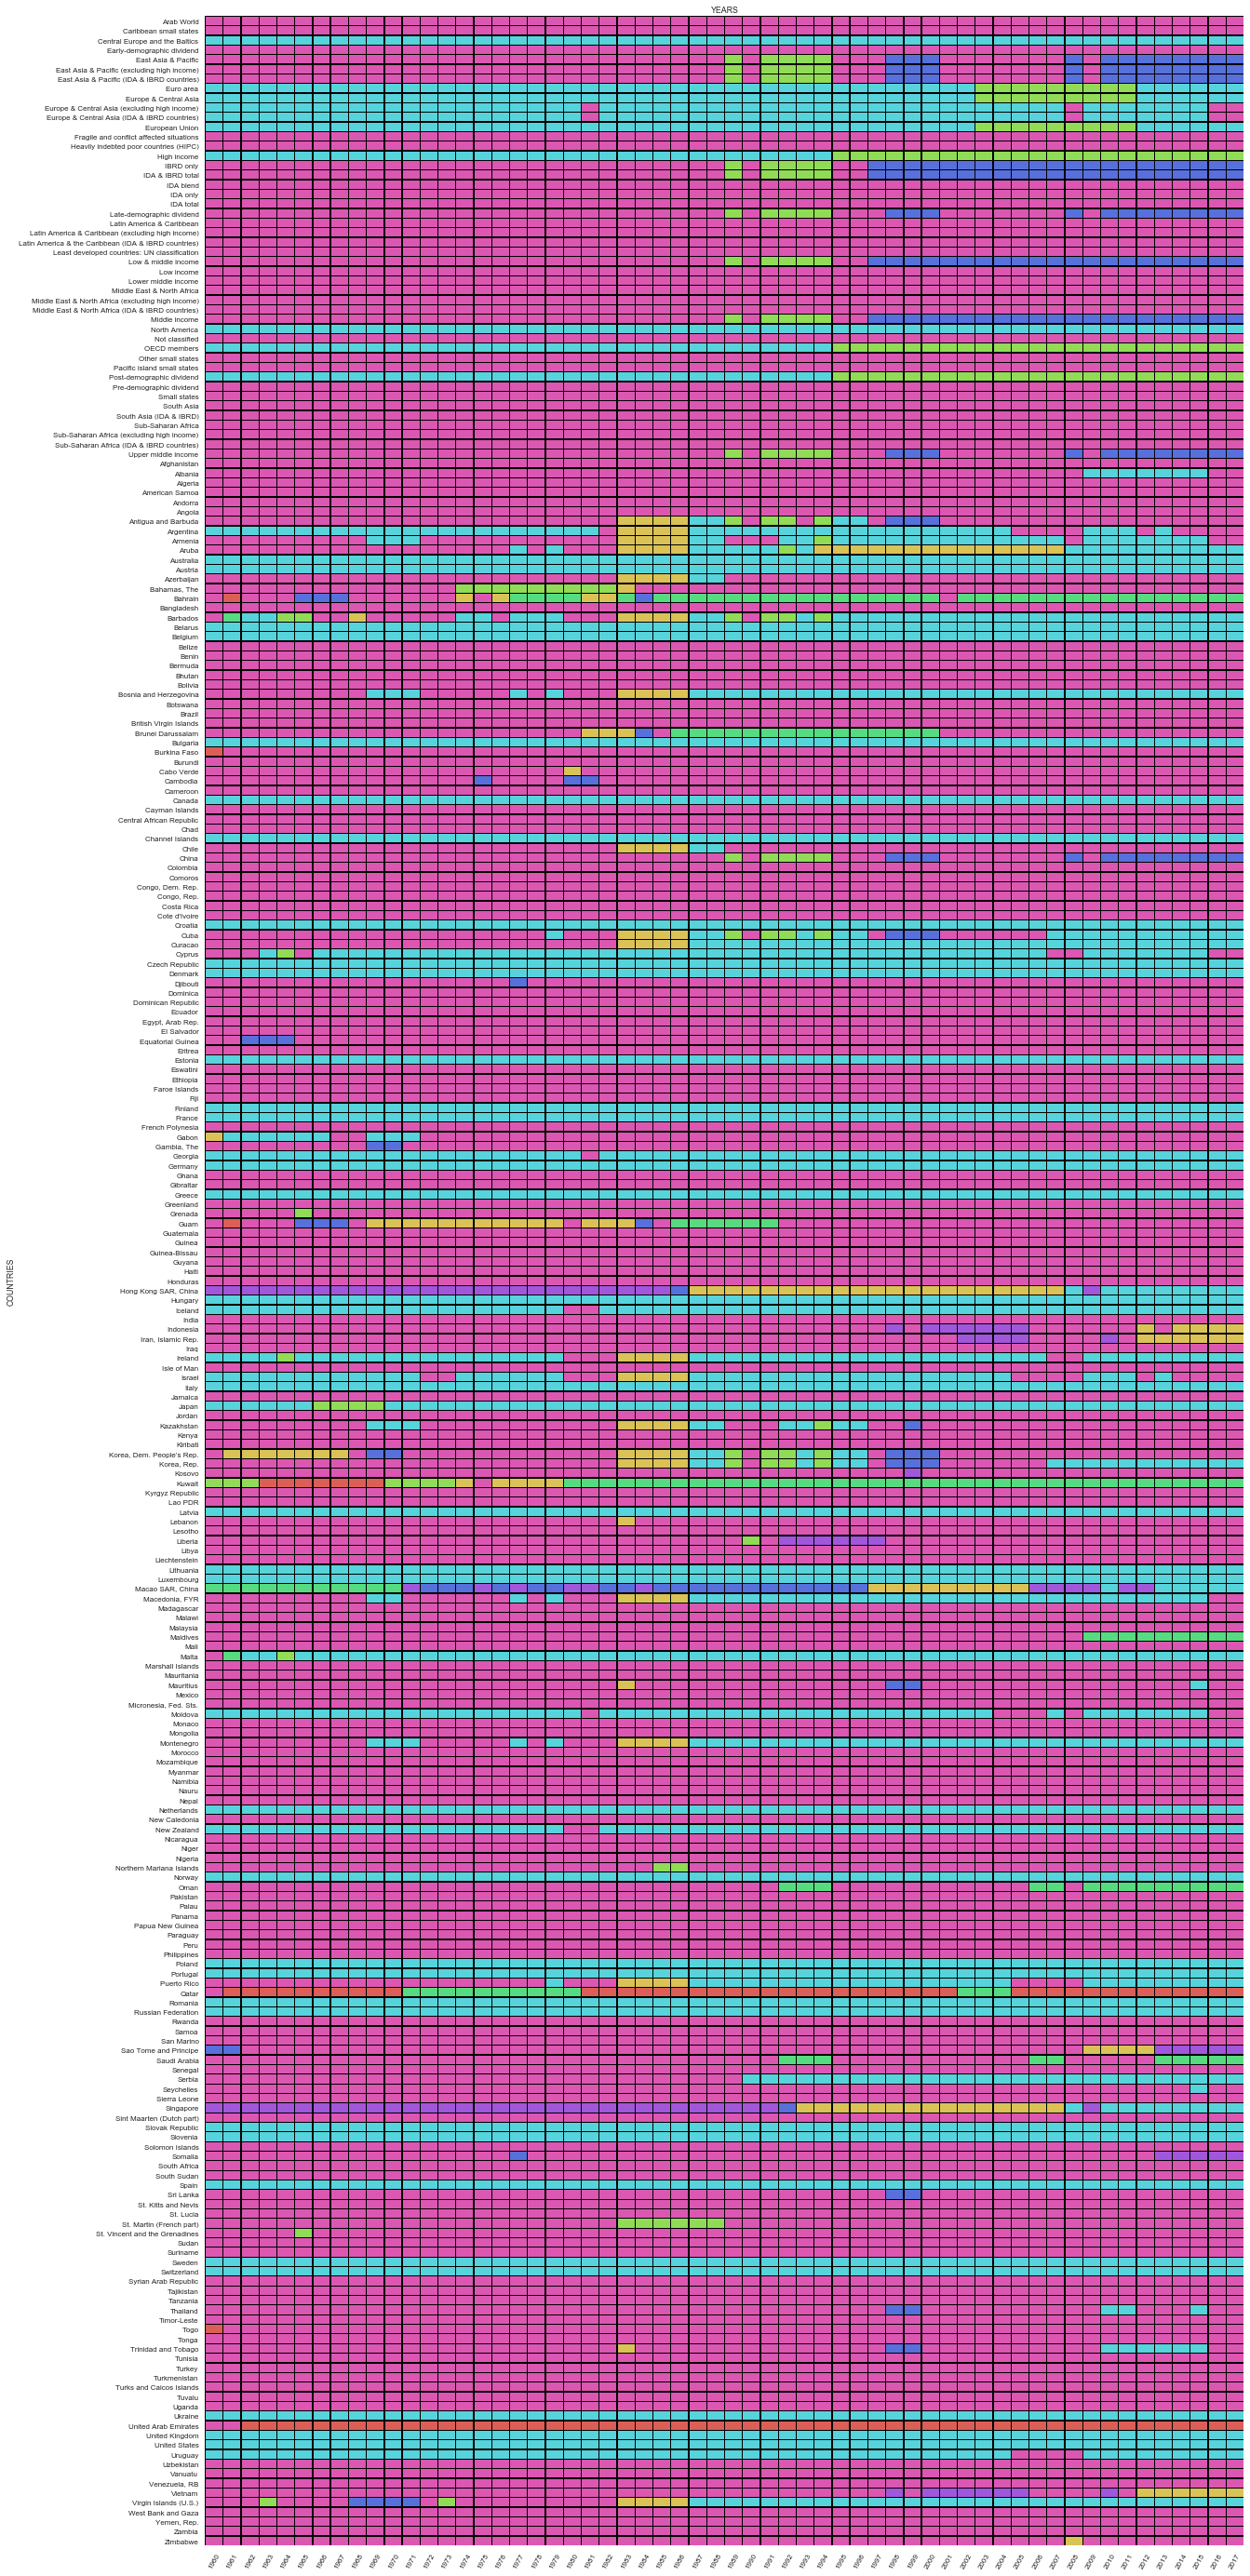

In [16]:
sns.set(font_scale=0.8, rc={'figure.figsize': (20, 50)})
ax = sns.heatmap(clusters_labels.T, cmap=cmap,
                 cbar=False, linewidths=.3, linecolor='black')

ax.set_ylabel('countries'.upper())
ax.set_xlabel('years'.upper())

ax.xaxis.set_label_position('top')
locs, labels = plt.xticks()
plt.xticks(locs, years)
locs, labels = plt.xticks()
plt.setp(labels, rotation=60)
locs, labels = plt.yticks()
plt.yticks(locs, countries_chosen)

plt.show()

Прослеживается следующая картина: В один кластер выделились страны Европы и Северной Америки. Судя по всему - это кластер богатых стран с высокой продолжительностью жизни. Его размер со временем становится больше, что говорит о том, что уровень жизни со временем растёт во многих странах.
Так же есть кластер стран Африки и Южной Америки, то есть бедные страны с низкой продолжительностью жизни, плохим образованием и прочими проблемами малообеспеченных стран.
Немного непонятно, как Казахстан попадает в один кластер с Китаем, Кореей и Сингапуром (Возможно это кластер узкоглазых).
Так же присутствуют несколько кластеров помнеьше.

# Контрольные вопросы
Постарайтесь максимально развернуто и честно ответить на вопросы. Они охватывают тему алгоритмов кластеризации и скорее нужны преподавателям, чтобы понимать, что именно Вы усвоили плохо. Надеюсь, они подскажут, что именно в теме Вы не понимаете или наоборот порадают, что Вы все знаете ^_^

* Опишите, пожалуйста, для каких прикладных задач Вы бы стали использовать методы кластеризации?

Кластеризацию я бы использовал в ситуациях, когда у меня внезапно появилось очень много не размеченных данных для анализа. Кластеризацией очень удобно сразу посмотреть на данные, увидеть некоторые группы.

* Какие преимущества и недостатки Вы видите у следуюших алгоритмов кластеризации: kmeans, dbscan, агломеративная кластеризация?

kmeans Очень сильно зависит от начальной инициализации, обязательно относит какой-либо элемент к одному из кластеров (не борется со случайными вбросами), кластеры имеют сферическую форму
Dbscan не имеет проблем kmeans, но у него есть два параметра, которые нужно ещё подбирать(тяжковато, кластеры могут быть разные по плотности)
Агломеративная кластеризация - отличная вещь, очень удобно разбивает на <вставить количество> кластеров, но может получиться так, что кластер растянется в длинную цепочку, что не есть хорошо, и так же она требует довольно много ресурсов.

* На лекции было показано, что EM алгоритм находит оценку максимального правдоподобия в задаче со сккрытыми переменными. Из курса мат. статистики Вы можете знать, оценка максимального правдоподобия "оптимальная" во многих смыслах. В каких же случаях тогда не следует применять метод максимального правдоподобия?

Когда функция правдоподобия, например, имеет очень много локальных максимумов, или неограничена(если такое бывает)

* Многие алгоритмы анализа данных страдают "проклятием" размерности. Страдают ли этим проклятием алгоритмы кластеризации? Если да, то как бы Вы с этим боролись?

Да, страдают. Алгоритмы кластеризации используют функцию расстояния, при большой размерности расстояние начинает играть злую шутку. Бороться можно, как обычно, понижением размерности, или например преобразовывать данные таким образом, чтобы более важные признаки играли большую роль при подсчёте расстояния.

* Представьте, что у Вас есть набор текстовых документов, и Вы хотите разбить эти документы на тематики - новости, спорт, кулинария, кино и так далее. Размеченной выборки у Вас нет, только сами тексты документов. Какие алгоритмы и какие признаки Вы бы использовали для решения данной задачи?

Составил бы словарик слов, уменьшил бы их количество (лематизацией, нормировованием и прочими методами), потом избавился бы от не имеющих смысловую нагрузку слов ("в", "на", "и", "но" и прочие) посчитал бы в каждом тексте количество этих слов, потом воспользовался бы кластеризацией (скорее всего методом kmeans).

* Теперь представьте, что небольшая часть Ваших текстов была размечена людьми, но большая часть так и осталась без таргета. Смогли ли бы Вы использовать эти данные для улучения качества кластеризации? (эта задача называется semi-supervised learning)

Наверное смог бы. Если, например, после кластеризации образовался кластер, в котором находятся элементы выборки, принадлежащие разным классам, я бы попробовал увеличить количество кластеров, чтобы получившийся кластер поделился на меньшие. Может быть и наоборот, если я получу два кластера, элементы которых размечены одним классом, то я соединю их.

Здесь Вы можете оставить отзыв о этой домашней работе или о всем курсе.   

*** ВАШ ОТЗЫВ ЗДЕСЬ***

Стильно модно молодёжно